# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
import math

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
227,0,28.0,54300.0,1,0
1713,1,35.0,42600.0,0,0
963,1,20.0,64100.0,0,0
3993,1,24.0,49700.0,1,0
2636,1,19.0,37000.0,2,0
4447,1,20.0,38800.0,1,0
3322,1,33.0,50900.0,3,0
2468,1,32.0,20600.0,2,0
1374,1,19.0,41600.0,2,0
3096,0,25.0,57600.0,4,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df[['age', 'income']] = df [['age', 'income']].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int64
 2   income              5000 non-null   int64
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [10]:
# Revisión de duplicados

df.duplicated().sum()

153

In [11]:
# Calculo del porcentaje de duplicados

print(df.duplicated().sum() / df.shape [0] * 100, "%")

3.06 %


In [12]:
# Eliminar duplicados

df = df.drop_duplicates().reset_index(drop=True)

In [13]:
# Tamaño del dataset

df.shape

(4847, 5)

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

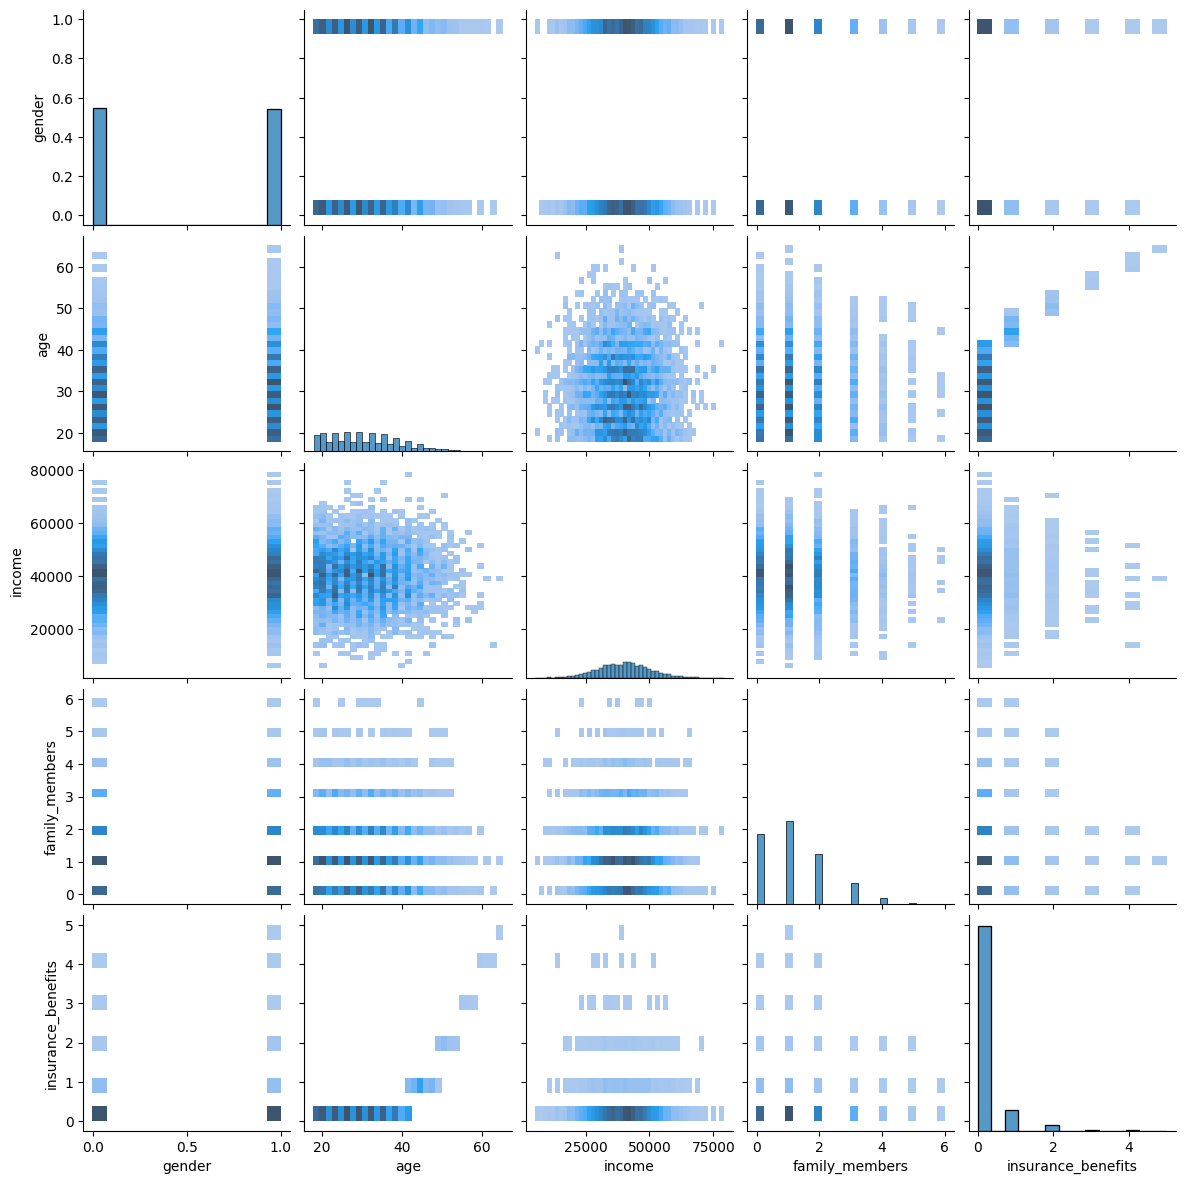

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = sklearn.neighbors.NearestNeighbors (n_neighbors = k, metric = metric, algorithm = 'brute')
    nbrs.fit(df[feature_names])# <tu código aquí> 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2347,1.0,0.553846,0.413924,0.166667,0
4670,0.0,0.507692,0.496203,0.000000,0
2043,1.0,0.307692,0.369620,0.000000,0
4148,1.0,0.615385,0.656962,0.000000,0
4619,0.0,0.369231,0.469620,0.500000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

#### Métrica Euclidiana 

In [19]:
# Uso de la función en el dataset con la métrica euclidiana, obteniendo los 5 puntos más cercanos al índice 1

get_knn(df, 1, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000,1,1,0.000000
3810,0,40,38000,0,0,6.082763
4796,1,37,38000,1,0,9.055385
2480,1,36,38000,0,0,10.099505
3498,0,33,38000,0,0,13.038405


In [20]:
# Uso de la función en el dataset escalado con la métrica euclidiana

get_knn(df_scaled, 1 , 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4041,0.0,0.707692,0.477215,0.166667,1,0.003797
1835,0.0,0.707692,0.492405,0.166667,1,0.011392
4833,0.0,0.723077,0.491139,0.166667,1,0.018418
4341,0.0,0.692308,0.459494,0.166667,1,0.026453


#### Métrica Manhattan

In [21]:
#Uso de la función en el dataset con la métrica Manhattan, obteniendo los 5 puntos más cercanos al indice 1

get_knn(df, 1, 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000,1,1,0.0
3810,0,40,38000,0,0,7.0
4796,1,37,38000,1,0,10.0
2480,1,36,38000,0,0,12.0
3498,0,33,38000,0,0,14.0


In [22]:
# Uso de la función en el dataset escalado con la métrica Manhattan

get_knn(df_scaled, 1 , 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4041,0.0,0.707692,0.477215,0.166667,1,0.003797
1835,0.0,0.707692,0.492405,0.166667,1,0.011392
4833,0.0,0.723077,0.491139,0.166667,1,0.025511
2394,0.0,0.676923,0.482278,0.166667,1,0.032035


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

- Los datos no escalados afectan el algoritmo kNN de manera significativa. Comparandolo con los datos escalados, generando resultados diferentes.

- Se puede notar más esta afectación en la columna objetivo '**insurance_benefits**' de los datos no escalados llevan a predicciones incorrectas, como en la que ciertos puntos objetivos con valor de 1 se agrupan con otros de valor de 0

- El uso de los datos escalados genera resultados más precisos.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

- Los resultados con ambas métricas son similares con los datos no escalados, con sus diferencias propias por ser diferentes métricas.

- Pero en los datos escalados, las métricas dan resultados diferentes, particularmente la del quinto punto. Euclidiana (4341), Manhattan (2394).

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [23]:
# сalcula el objetivo
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] == 0, 0 , 1)

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

<AxesSubplot:>

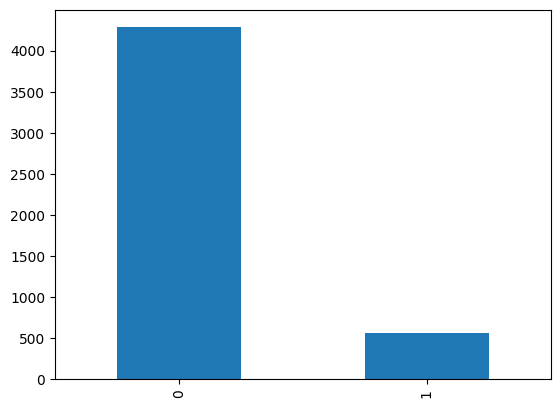

In [24]:
# comprueba el desequilibrio de clases con value_counts()

display(df['insurance_benefits_received'].value_counts())
df['insurance_benefits_received'].value_counts().plot(kind='bar')

La clase no está balanceada, ya que la mayoría de clientes no recibe una prestación del seguro.

In [25]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize = 'all')
    print('Matriz de confusión')
    print(cm)

In [26]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict (P, size = len(df), seed = 42) # <tu código aquí> 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

La probabilidad: 0.12
F1: 0.13
Matriz de confusión
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

La probabilidad: 0.50
F1: 0.19
Matriz de confusión
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

La probabilidad: 1.00
F1: 0.21
Matriz de confusión
[[0.         0.88384568]
 [0.         0.11615432]]



In [28]:
# División 70:30 del conjunto de entrenamiento

y = df['insurance_benefits_received']
x = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.3, random_state= 12345)

In [29]:
# Modelo para examinar el valor f1 en los datos no escalados

model1 = sklearn.neighbors.KNeighborsClassifier()
model1.fit(x_train, y_train)
predict_test = model1.predict(x_test)

In [30]:
# Uso de la función 'eval_classifier' previamente creada

eval_classifier (y_test, predict_test)

F1: 0.23
Matriz de confusión
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]


In [31]:
# Escalando los datasets
scaler = sklearn.preprocessing.MaxAbsScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
# Modelos basados en datos escalados
model2 = sklearn.neighbors.KNeighborsClassifier()
model2.fit(x_train_scaled, y_train)
predict_test_sc = model2.predict(x_test_scaled)

In [33]:
# Uso de la función eval_classifier 
eval_classifier (y_test, predict_test_sc)

F1: 0.90
Matriz de confusión
[[0.87972509 0.004811  ]
 [0.01786942 0.0975945 ]]


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis = 1 ) # <tu código aquí>
        y_pred = np.dot(X2, self.weights) # <tu código aquí>
        
        return y_pred

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

### Evaluación RMSE para datos no escalados

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366679e-01  3.58042290e-02  1.95594897e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


### Evaluación RMSE para datos escalados

In [37]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668  2.32727489  0.01955949  0.04624147 -0.07297106]
RMSE: 0.36
R2: 0.66


###### Conclusión:

Los valores del RMSE y R2 son relativamente similares entre los datos escalados y no escalados.

El valor relativamente bajo del RMSE en los datos escalados y no escalados, indican que el modelo funciona bien.

El valor R2 de 0.66 indcia un nivel de error relativamente bajo.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [40]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Comprobar que la matriz P sea invertible

In [41]:
P_inv = np.linalg.inv(P)
P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [42]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

True

La matriz es inversible

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [43]:
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

In [44]:
X_trans = X.dot(P)
X_trans

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Los datos transformados no permite poder adivinar los datos originales

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [45]:
# Recuperación de datos

X_rec = X_trans.dot(P_inv)
X_rec

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Los datos originales pueden ser restaurados usando el valor inverso de la matriz P

Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [46]:
#Datos originales

pd.DataFrame (X, columns = personal_info_column_list).head()

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


In [47]:
# Datos después de la transformación

pd.DataFrame (X_trans, columns = personal_info_column_list).head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [48]:
# Datos restaurados al estado original

pd.DataFrame (X_rec, columns = personal_info_column_list).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Los datos recuperados en las columnas 'gender' y 'family_members' producen valores ligeramente diferentets a los datos originales.

Al haber calculos que involucran números con escalas bien amplias y distintas, como valores muy grandes y valores pequeños, puede haber una pequeña perdida en la precisión por la diferencia de escalas, conocido como error punto flotante.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

La ofuscación de datos impacta las predicciones de regresión lineal

La fórmula de calculo de pesos (w):

$$w = (X^T X)^{-1} X^T y$$

Después de la ofuscación, se tiene $X x P$ en vez de $X$ y los nuevos pesos se calcularían como:

$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Se tratará demostrar que el $w_P$ no alterará los valores predichos comparados a el $w$ original obtenido de data no ofuscada

**Parte 1:**

Expresando $w$ en términos de $w_P$ y $P$:

Primero se cambiará $w_P$:

$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Expandir productos de matriz:

$$w_P = (P^T X^T X P)^{-1} P^T X^T y$$

Como $P$ es una matriz invertida, la ecuación sería:

$$w_P = P^{-1} (X^T X)^{-1} P^{-1} P^T X^T y$$

Identificar la matriz, teniendo en cuenta que $P^{-1} P = I$:

$$w_P = P^{-1} (X^T X)^{-1} X^T y$$

Como $w = (X^T X)^{-1} X^T y$ tenemos:

$$w_P = P^{-1} w$$

**Parte 2:**

Implicaciones de $w_P = P^{-1} w$:

La ecuación $w_P = P^{-1} w$ demuestra que los pesos obtenidos de la data ofuscada ($w_P$) tienen relación directa con los pesos de la data original ($w$) en la inversión de la matriz ofuscada $P$. Significa que la multiplicación de los pesos originales por la matriz ofuscada inversa($P^{-1}$) va a darnos los pesos obtenidos de la data ofuscada ($w_P$).

**Parte 3:**

Predicciones usando $w_P$

Ahora veremos la predicción que usa $w_P$ esta relacionada con la predicción original que usaba $w$:

Predicción $w$ original:

$$\hat{y} = Xw$$

Predicción usando $w_P$:

$$\hat{y}_P = XPw_P$$

Se sustituye $w_P = P^{-1} w$:

$$\hat{y}_P = XP (P^{-1} w)$$

Podemos simplificar $XP(P^{-1})$ a $X$:

$$\hat{y}_P = Xw = \hat{y}$$

**Conclusión**:

Se encontró que las predicciones realizadas con el peso original $w$ y los pesos de la data ofuscada $w_P$ son las mismas. Por lo tanto la ofuscación de datos no afecta los valores predichos por la regresión lineal.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [49]:
# Creación de matriz cuadrada

rng = np.random.default_rng(seed = 12345)
P2 = rng.random(size = (X.shape [1], X.shape[1]))

In [50]:
# Revisar si la  matriz es inversible

np.allclose(np.dot(P2, np.linalg.inv(P2)), np.dot(np.linalg.inv(P2), P2))

True

###### Creación de modelo de regresión lineal

In [51]:
# Uso de datos iniciales escalados, pero no ofuscados (no P2)

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict (X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668  2.32727489  0.01955949  0.04624147 -0.07297106]
RMSE: 0.36
R2: 0.66


In [52]:
# Uso no escalado, pero ofuscado (con P2)

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(np.dot(X, P2), y, test_size = 0.3, random_state = 12345)

lr = MyLinearRegression()

lr.fit(X_train_P, y_train_P)
print(lr.weights)

y_test_pred_P = lr.predict (X_test_P)
eval_regressor(y_test_P, y_test_pred_P)

[-0.97736683 -0.05106697  0.02701986  0.05239091 -0.00431772]
RMSE: 0.36
R2: 0.66


Los valores de precisión en ambos modelos es igual.

# Conclusiones

En el proyecto se usó la álgebra linear en el análisis, dando los resultados:

- Utilizando el algoritmo ´kNearestNeighbor' (kNN) para identificar los clientes similares al cliente objetivo, aplicando las distancias métricas Euclidianas y Manhattan.

- El como los datos escalados en el algoritmo kNN, llevó a tener diferentes resultados al de los datos no escalados.

- Se verificó el desempeño del algoritmo ante datasets de entrenamiento y prueba, encontrando que los datos escalados tenían una mayor precisión comparada a los datos no escalados.

- Usando el modelo 'Linear Regression', no se encontró una diferencia significativa entre los valores de precisión de datos escalados y no escalados.

- Usando el álgebra linear se aplicó la ofuscación de datos. Aunque los datos ofuscados volvian irreconocible a los datos originales, se podían reestablecer con pequeñas diferencias con el valor de la métrica P inversa.

- Se comprobó analiticamente que los datos ofuscados seguían siendo viables para análisis con el algoritmo de Regresión Linear al demostrar la equivalencia entre los datos originales y los datos ofuscados.

- Los valores de precisión iguales de RMSE y $R^2$ demostraron que el algoritmo de Regresión Linear funciona efectivamente en los datos ofuscados.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [ ]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas    
    - [ ]  Se respondieron las preguntas sobre la escala/distancia
- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    
    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.
- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales    
    - [ ]  Se calculó la RECM para la solución implementada
- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    
    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    
    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    
    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM
    - [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>